In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
# is reviews_per_month total listings per host? So may need divide by their number of listings
# 

reviews_m = pd.read_csv("/Users/bridmcnulty/Desktop/reviews.csv", low_memory=False)
reviews_f = pd.read_csv("/Users/bridmcnulty/Desktop/reviews1.csv", low_memory=False)
                      
reviews_m.shape

(1249466, 6)

In [3]:
reviews_m.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,13913,80770,2010-08-18,177109,Michael,My girlfriend and I hadn't known Alina before ...
1,13913,367568,2011-07-11,19835707,Mathias,Alina was a really good host. The flat is clea...
2,13913,529579,2011-09-13,1110304,Kristin,Alina is an amazing host. She made me feel rig...
3,13913,595481,2011-10-03,1216358,Camilla,"Alina's place is so nice, the room is big and ..."
4,13913,612947,2011-10-09,490840,Jorik,"Nice location in Islington area, good for shor..."


In [4]:
frames = [reviews_m, reviews_f]

df = pd.concat(frames)

In [5]:
df.shape

(2480777, 6)

In [6]:
df.drop(columns=['id','reviewer_id','reviewer_name','date'],inplace=True)

In [7]:
df.head()

,listing_id,comments
0,13913,My girlfriend and I hadn't known Alina before ...
1,13913,Alina was a really good host. The flat is clea...
2,13913,Alina is an amazing host. She made me feel rig...
3,13913,"Alina's place is so nice, the room is big and ..."
4,13913,"Nice location in Islington area, good for shor..."


In [8]:
df.comments.dtypes

dtype('O')

In [9]:
# 850 null comment rows dropped:

df.dropna(subset=['comments'],inplace=True)

In [10]:
# Each comment is a pair of strings, they need to be combined:
test = df['comments'][1]
test

1    Alina was a really good host. The flat is clea...
1    My bnb request was very last minute and i was ...
Name: comments, dtype: object

In [15]:
# Create a list for that combines each listing's pair of strings into one:

l = []
for x in range(len(df.comments)):
    try:
        test = df.comments[x]
        l.append("".join(test))
    except:
        l.append(test)

In [16]:
# Set l as a new comments_combined column:
df['comments_combined'] = l

In [17]:
df.comments_combined.isnull().sum()

0

In [18]:
# Save to csv because acquiring 'l' took many hours:
df.to_csv("reviews_comments_combined.csv")

In [11]:
# Read back in:
df = pd.read_csv("/Users/bridmcnulty/Desktop/reviews_comments_combined.csv")

In [12]:
df.head()

,Unnamed: 0,listing_id,comments,comments_combined
0,0,13913,My girlfriend and I hadn't known Alina before ...,My girlfriend and I hadn't known Alina before ...
1,1,13913,Alina was a really good host. The flat is clea...,Alina was a really good host. The flat is clea...
2,2,13913,Alina is an amazing host. She made me feel rig...,Alina is an amazing host. She made me feel rig...
3,3,13913,"Alina's place is so nice, the room is big and ...","Alina's place is so nice, the room is big and ..."
4,4,13913,"Nice location in Islington area, good for shor...","Nice location in Islington area, good for shor..."


# Sentiment Analysis with Textacy

In [6]:
from tqdm import tqdm_notebook
import textacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [12]:
sents = pd.read_csv('./word_sentiments.csv')

In [13]:
sents.head()

,pos,word,pos_score,neg_score,objectivity,pos_vs_neg
0,ADJ,.22-caliber,0.0,0.0,1.0,0.0
1,ADJ,.22-calibre,0.0,0.0,1.0,0.0
2,ADJ,.22_caliber,0.0,0.0,1.0,0.0
3,ADJ,.22_calibre,0.0,0.0,1.0,0.0
4,ADJ,.38-caliber,0.0,0.0,1.0,0.0


In [14]:
# Create the sen_dict from df:

from collections import defaultdict
sen_dict = defaultdict(dict) # set up a default dictionary with an empty dictionary as default value

for row in tqdm_notebook(sents.itertuples()):
    sen_dict[row.pos] [row.word] = {'objectivity': row.objectivity, 'pos_vs_neg': row.neg_score}

In [15]:
# Engineer an initial feature of title length:

df['comment_length'] = [len(t.split()) for t in df['comments_combined']]

In [16]:
df.head()

,Unnamed: 0,listing_id,comments,comments_combined,comment_length
0,0,13913,My girlfriend and I hadn't known Alina before ...,My girlfriend and I hadn't known Alina before ...,318
1,1,13913,Alina was a really good host. The flat is clea...,Alina was a really good host. The flat is clea...,103
2,2,13913,Alina is an amazing host. She made me feel rig...,Alina is an amazing host. She made me feel rig...,239
3,3,13913,"Alina's place is so nice, the room is big and ...","Alina's place is so nice, the room is big and ...",144
4,4,13913,"Nice location in Islington area, good for shor...","Nice location in Islington area, good for shor...",147


In [17]:
# Complete a sentiment analysis manually using the sen_dict:

en_nlp = textacy.load_spacy('en_core_web_sm')

def process_text(documents, pos=False):
    nlp = textacy.load_spacy('en_core_web_sm')
    
    texts = []
    tokenised_texts = []

    if pos: # pos can either be False or a list of parts of speech
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ in pos
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
    
    
    else:    
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
            
    return texts, tokenised_texts

In [18]:
pos = ['NOUN', 'ADJ', 'VERB', 'ADV']

In [ ]:
processed_titles, tokenised_titles = process_text(df['comments_combined'], pos=pos)

In [ ]:
df['processed_title'] = processed_titles
df['tokenised_title'] = tokenised_titles
df.head()

In [ ]:
def scorer(parsed):
    
    obj_scores, pvn_scores = [], []
    
    for token in parsed:
        try:
            obj_scores.append(sen_dict[token.pos_][token.lemma_]['objectivity'])
            pvn_scores.append(sen_dict[token.pos_][token.lemma_]['pos_vs_neg'])
        except:
            pass
    
    if not obj_scores:
        obj_scores = [1.]
    if not pvn_scores:
        pvn_scores = [0.]
        
    return [np.mean(obj_scores), np.mean(pvn_scores)]

In [ ]:
scores = df['tokenised_title'].map(scorer)
df['objectivity_avg'] = scores.map(lambda x: x[0])
df['polarity_avg'] = scores.map(lambda x: x[1])

In [ ]:
df.head()

In [ ]:
df.to_csv("reviews_comments_processed.csv")

# Vader

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [7]:
analyzer = SentimentIntensityAnalyzer()
for sentence in df.comments_combined.values[0:2]:
    vs = analyzer.polarity_scores(sentence)
    print(sentence)
    print(vs)

My girlfriend and I hadn't known Alina before we took the leap of faith to rent her flat. Alina just couldn't be nicer! Her flat is comfortable, homey, very sunny, and quiet at night. Her diverse neighborhood rocks! It's full of excellent eateries of varying ethnicities, good supermarkets, etc., etc. Her place is about a 10-minute walk to the Finsbury Park tube stop, and there are also several buses that ply Stroud Green Road. The Piccadilly and Victoria tube lines that serve Finsbury Park are very dependable and come frequently. My only caveat is if you are unwilling to take 20- to 40-minute commutes to downtown London attractions and money is no object, you will prefer to stay downtown. But for anyone else, you will love your experience of living in a real, untouristy neighborhood and dealing with a generous, warm-hearted woman I'm happy to call a new friend.I  stayed  in London for a month to study, explore the city, and meet people along the way.  

I think the area is a great plac

In [8]:
vader_scores = df['comments_combined'].map(analyzer.polarity_scores)

In [9]:
vader_scores.head()

0    {'neg': 0.013, 'neu': 0.743, 'pos': 0.243, 'co...
1    {'neg': 0.045, 'neu': 0.758, 'pos': 0.197, 'co...
2    {'neg': 0.0, 'neu': 0.736, 'pos': 0.264, 'comp...
3    {'neg': 0.0, 'neu': 0.71, 'pos': 0.29, 'compou...
4    {'neg': 0.0, 'neu': 0.754, 'pos': 0.246, 'comp...
Name: comments_combined, dtype: object

In [11]:
from sklearn.feature_extraction import DictVectorizer
dvec = DictVectorizer()

vader_scores = dvec.fit_transform(vader_scores)
vader_scores

<2479927x4 sparse matrix of type '<class 'numpy.float64'>'
	with 5451988 stored elements in Compressed Sparse Row format>

In [12]:
dvec.feature_names_

['compound', 'neg', 'neu', 'pos']

In [13]:
for i, col in enumerate(dvec.feature_names_):
    df['vader_{}'.format(col)] = vader_scores[:, i].toarray().ravel()

In [14]:
df.head(2)

,Unnamed: 0,listing_id,comments,comments_combined,vader_compound,vader_neg,vader_neu,vader_pos
0,0,13913,My girlfriend and I hadn't known Alina before ...,My girlfriend and I hadn't known Alina before ...,0.9982,0.013,0.743,0.243
1,1,13913,Alina was a really good host. The flat is clea...,Alina was a really good host. The flat is clea...,0.9370,0.045,0.758,0.197


In [16]:
for quote in df.sort_values('vader_neg', ascending=False)['comments_combined'][0:10]:
    print(quote)
    print('============================================================\n')
    
    # This is interesting - the comments_combined feature joined the two reviews one guest gives for a host (perhaps the two reviews are displayed in different places)
    # It seems people aren't always genuine in what they say - in one review they say 'Not good', and the next 'Ideal :)'. Maybe one is public and one is sent to the host so people try to be polite.
    

Sorry

Sadly disappointed

No.

Dreadful.

Dishonest

Not good . Ideal :)

HORRIBLE EXPERIENCE!!!Good

Great!not bad

No BreakFast.
I don't recommend. Fantastic location!

No complaintsøjkhø



In [17]:
for quote in df.sort_values('vader_pos', ascending=False)['comments_combined'][0:10]:
    print(quote)
    print('============================================================\n')

Good value

Recommended!

Perfect! :-)

Nice

awesome

good

AMAZING

Lovely

ok

Good



In [18]:
# Save to csv because acquiring 'l' took many hours:
df.to_csv("reviews_vader.csv")

In [20]:
# what i want is listing_id, average vader scores, comment_length_avg
# Engineer an initial feature of title length:

df['comment_length'] = [len(t.split()) for t in df['comments_combined']]

In [28]:
# Group each listing's average scores together:

averages = df.groupby('listing_id')[['vader_neg','vader_pos','vader_neu','vader_compound','comment_length']].mean()

In [29]:
averages

,vader_neg,vader_pos,vader_neu,vader_compound,comment_length
listing_id,,,,,
9554,0.019522,0.330821,0.649664,0.650421,33.156716
13913,0.005857,0.289536,0.704571,0.752046,88.464286
15400,0.014648,0.282901,0.702463,0.798762,92.796296
17402,0.018679,0.255654,0.725679,0.714194,82.653846
24328,0.012598,0.294549,0.692832,0.769610,87.081522
25023,0.015538,0.301308,0.683173,0.752223,74.903846
25123,0.008220,0.187847,0.803936,0.550693,70.411017
26223,0.008339,0.142298,0.849372,0.483331,71.553719
26482,0.010153,0.142073,0.847773,0.458544,66.380000


In [33]:
averages.comment_length.corr(averages.vader_compound)

0.3591181506038425

(array([6.0000e+00, 5.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        4.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 4.0000e+00, 2.8000e+01, 4.6000e+01, 2.2000e+01,
        1.7000e+01, 1.8000e+01, 3.0000e+01, 2.7000e+01, 1.7000e+01,
        3.0000e+01, 3.6000e+01, 3.2000e+01, 3.6000e+01, 3.8610e+03,
        1.0700e+02, 1.0300e+02, 1.3200e+02, 2.1000e+02, 3.2800e+02,
        4.9900e+02, 7.1700e+02, 1.2600e+03, 2.2320e+03, 4.3500e+03,
        9.2870e+03, 1.9773e+04, 1.4216e+04, 1.1330e+03, 5.5000e+02,
        3.4500e+02, 2.9500e+02, 1.8500e+02, 1.7900e+02, 1.7800e+02,
        2.6600e+02, 3.2400e+02, 4.6400e+02, 6.2300e+02, 6.9100e+02]),
 array([-0.9957  , -0.955822, -0.915944, -0.876066, -0.836188, -0.79631 ,
        -0.756432, -0.716554, -0.676676, -0.636798, -0.59692 , -0.557042,
        -0.517164, -0.477286, -0.437408, -0.39753 , -0.357652, -0.317774,
        -0.277896, -0.238018, -0.19814 , -0.158262, -0.118384, -0.078506,
        -0.038628,  0.

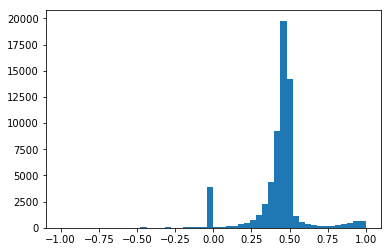

In [37]:
plt.hist(averages.vader_compound,bins=50)

In [ ]:
# Bring in data_cleaned file. Merge reviews grouped stuff onto data_cleaned joining on listing_id.
# Any nulls on vader scores - put as neutral rather than deleting rows.
# Shouldn't be any nulls as deleted people without reviews I believe.

In [38]:
averages.to_csv("/Users/bridmcnulty/Desktop/reviews_vader_scores.csv")

In [13]:
income_classes = pd.read_csv("/Users/bridmcnulty/Desktop/id_and_income_class_imbalanced.csv")
income_classes.drop(columns=['Unnamed: 0'],inplace=True)
income_classes.head(2)

,id,income_class
0,13913,D
1,15400,C


In [14]:
df = df.merge(income_classes, how='left',left_on='listing_id',right_on='id')
df.head(2)

,Unnamed: 0,listing_id,comments,comments_combined,id,income_class
0,0,13913,My girlfriend and I hadn't known Alina before ...,My girlfriend and I hadn't known Alina before ...,13913.0,D
1,1,13913,Alina was a really good host. The flat is clea...,Alina was a really good host. The flat is clea...,13913.0,D


In [15]:
# Subset each income class to do word clouds on:

A = df[df['income_class']=='A']
B = df[df['income_class']=='B']
C = df[df['income_class']=='C']
D = df[df['income_class']=='D']

In [ ]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 

comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in A.comments_combined: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()